### Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import requests
from io import BytesIO

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

### Data Extraction and Pre-Processing

##### Loading the csv file which was generated by selenium

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Internship Project/artyvis/images.csv')

In [ ]:
df.head()

,link,description,id
0,"https://assets.myntassets.com/dpr_2,q_60,w_210...",Nayo Women Orange & Off-White Striped Straight...,0
1,"https://assets.myntassets.com/dpr_2,q_60,w_210...",Jaipur Kurti Women Navy Blue Yoke Design Kurta...,1
2,"https://assets.myntassets.com/dpr_2,q_60,w_210...",AHIKA Women Green & Off-White Printed Straight...,2
3,"https://assets.myntassets.com/dpr_2,q_60,w_210...",ADA Women Yellow & White Chikankari Hand Embro...,3
4,"https://assets.myntassets.com/dpr_2,q_60,w_210...",Soch Women Navy Blue & Grey Dyed Straight Kurta,4


In [ ]:
len(df)

12305

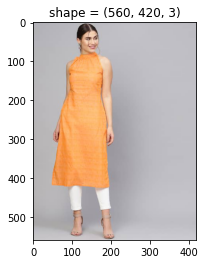

In [ ]:
response = requests.get(df['link'].iloc[0])
sample_img = Image.open(BytesIO(response.content))
sample_img = np.array(sample_img)
plt.imshow(sample_img)
plt.title(f'shape = {sample_img.shape}');

##### Data Pre-Preprocessing steps -:

1. Remove Men's data since this project is focused only on women data

2. Fetching Dress type(kurta-kurtis, Sarees etc.) type from description

In [ ]:
# Removing Men's data

def is_women(x):
  x=x.lower()
  x = x.split(" ")
  if "women" in x:
    return 1
  return 0

df['is_women'] = df['description'].apply(is_women)

df = df[df['is_women'] == 1]
len(df)

2657

In [ ]:
df['description'].iloc[1]

'Jaipur Kurti Women Navy Blue Yoke Design Kurta with Trousers'

In [ ]:
#Fetching Dress type

#manually setting dress type and its label
dress_to_idx = {
    'kurta' : 0,
    'kurti' : 0,
    'saree' : 1,
    'lehenga' : 2,
    'dress' : 3,
    'shirt' : 4,
    'top' : 5
}

def get_dress_type(x):
  x = x.lower()

  for key,item in dress_to_idx.items():
    if key in x:
      return item
  return 6

df['dress_type'] = df['description'].apply(get_dress_type)
df = df[df['dress_type'] != 6]
len(df)

2603

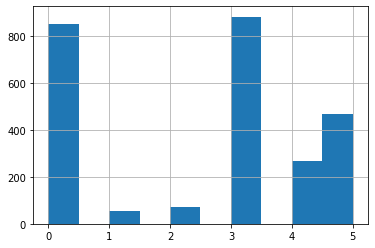

In [ ]:
df['dress_type'].hist()

In [ ]:
#make and save the array
images_arr = []
labels = []

for i in df.iterrows():
  labels.append(i[1]['dress_type'])
  response = requests.get(i[1]['link'])
  img = np.array(Image.open(BytesIO(response.content)))
  img = tf.image.resize(img,(256,256))
  images_arr.append(img/255.0)

X = np.array(images_arr)
y = np.array(labels)

#save the array
np.save('/content/drive/MyDrive/Internship Project/artyvis/X.npy',X)
np.save('/content/drive/MyDrive/Internship Project/artyvis/y.npy',y)

### Load the numpy array

In [ ]:
#load the array
X = np.load('/content/drive/MyDrive/Internship Project/artyvis/X.npy')
y = np.load('/content/drive/MyDrive/Internship Project/artyvis/y.npy')

### Build and train the model

In [ ]:
from tensorflow.keras.applications import Xception
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3)
)

83697664/83683744 [==============================] - 2s 0us/step


In [ ]:
def make_model():
  inputs = tf.keras.layers.Input((256,256,3))
  x = base_model(inputs)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(120,activation='relu')(x)
  x = tf.keras.layers.Dense(6,activation='softmax')(x)

  return tf.keras.models.Model(inputs,x)

In [ ]:
model = make_model()

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 120)               245880    
                                                                 
 dense_3 (Dense)             (None, 6)                 726       
                                                                 
Total params: 21,108,086
Trainable params: 21,053,558
Non-trainable params: 54,528
__________________________________________

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=["accuracy"])
model.fit(X,y,epochs=5,batch_size=32)

Epoch 1/5
82/82 [==============================] - 139s 2s/step - loss: 0.3808 - accuracy: 0.8675
Epoch 2/5
82/82 [==============================] - 128s 2s/step - loss: 0.2564 - accuracy: 0.9132
Epoch 3/5
82/82 [==============================] - 128s 2s/step - loss: 0.1715 - accuracy: 0.9374
Epoch 4/5
82/82 [==============================] - 128s 2s/step - loss: 0.1205 - accuracy: 0.9600
Epoch 5/5
82/82 [==============================] - 128s 2s/step - loss: 0.1031 - accuracy: 0.9670


In [ ]:
model.save('image_tagging_model.h5')

In [ ]:
#load the model for testing
model = tf.keras.models.load_model('/content/drive/MyDrive/Internship Project/artyvis/image_tagging_model.h5')

In [ ]:
y_pred = np.argmax(model.predict(X[:4]),axis=-1)

In [ ]:
y_pred,y[:4]

(array([0, 0, 0, 0]), array([0, 0, 0, 0]))